# Importing

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch.nn as nn
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import ConcatDataset, random_split, TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

#Part 1

## Kalhor_SeparationIndex

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class Kalhor_SeparationIndex:
    def __init__(self, data, label, normalize=False):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if not normalize:
            self.data = data.to(device)
        else:
            small_number = 1e-10
            mean_data = data.mean(0)
            std_data = data.std(0) + small_number
            data = (data - mean_data.reshape([1, -1]).repeat(data.shape[0], 1)) / std_data.reshape([1, -1]).repeat \
                (data.shape[0], 1)
            self.data = data
            print('data becomes normalized')
        self.device1 = device
        self.label_min = round(torch.min(label).detach().item())
        self.label = (label - self.label_min).to(device)
        # "dis_matrix" denotes an "Euclidean" distance matrix where "kth" row denotes the distance of "kth" input data point with all n_data data points.
        self.big_number = 1e10
        self.data = self.data.float().to(device)
        self.dis_matrix = torch.cdist(self.data, self.data, p=2).fill_diagonal_(self.big_number).to(device)
        self.n_class = round(torch.max(self.label).detach().item()) + 1
        self.n_data = self.data.shape[0]
        self.n_feature = self.data.shape[1]



    def forward_feature_ranking_si(self):
        ranked_features = torch.zeros(1, 0)
        temp = torch.zeros(1, 1)
        rest_features = torch.arange(self.n_feature)
        si_ranked_features = torch.zeros(self.n_feature, 1, device=self.device1)

        data_3d = self.data.reshape([-1, 1, self.n_feature]).repeat([1, self.n_data, 1]).to(self.device1)
        tr_data_3d = data_3d.transpose(0, 1)
        distanc_3d = data_3d ** 2
        tr_distanc_3d = distanc_3d.transpose(0, 1)
        eye_3d = torch.eye(self.n_data, device=self.device1).reshape([self.n_data, self.n_data, 1]).repeat(
            [1, 1, self.n_feature])
        dis_matrix_features = eye_3d * self.big_number + distanc_3d + tr_distanc_3d - 2 * (data_3d * tr_data_3d)
        for k_forward in tqdm(range(self.n_feature)):
            si_max = 0
            for k_search in range(len(rest_features)):
                ranked_features_search = np.append(ranked_features, rest_features[k_search])

                dis_features_search = torch.sum(dis_matrix_features[:, :, ranked_features_search], 2)
                values, indices = torch.min(dis_features_search, 1)
                si = torch.sum(self.label[indices, :] == self.label).detach() / self.n_data
                if si > si_max:
                    si_max = si
                    chosen_feature = rest_features[k_search]
                    k_search_chosen = k_search
            temp[:, 0] = chosen_feature.detach()
            ranked_features = torch.cat((ranked_features, temp), 1)
            rest_features = torch.cat([rest_features[:k_search_chosen], rest_features[k_search_chosen + 1:]])
            si_ranked_features[k_forward, 0] = si_max
        return si_ranked_features, ranked_features

## Model

In [ ]:
# Define the AlexNet model
class AlexNet(nn.Module):
    def __init__(self, num=10):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32*9*9,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num),

        )

    def forward(self, x):

        x = self.feature(x)
        # print(x.shape)
        x = x.view(-1,32*9*9)
        x = self.classifier(x)
        return x

In [ ]:
# Load trained model checkpoint
model_checkpoint = torch.load("/content/drive/MyDrive/D.L/HW1/Q2/trained_model2.pth")

In [ ]:
# Create the model
model = AlexNet()
model.load_state_dict(model_checkpoint)
model.eval()  # Set the model to evaluation mode

AlexNet(
  (feature): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequent

##Train DataSet

In [ ]:
# Define the transformations
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
#Download train dataset from mnist dataset
dataset  = torchvision.datasets.MNIST(root='./data',train=True,transform=transform,download=True)


num_samples_per_class = 122


total_samples = num_samples_per_class * 10


class_indices = dataset.targets.unique()
datasets_per_class = []
for class_index in class_indices:
    class_samples = [i for i, label in enumerate(dataset.targets) if label == class_index]
    selected_samples = class_samples[:num_samples_per_class]
    selected_dataset = torch.utils.data.Subset(dataset, selected_samples)
    datasets_per_class.append(selected_dataset)

dataset = ConcatDataset(datasets_per_class)

# dataset = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
# Get the data and labels from the test set:
train_images = torch.stack([dataset[i][0] for i in range(len(dataset))])
train_labels = torch.tensor([dataset[i][1] for i in range(len(dataset))])

#reshape labels
train_labels = train_labels.view(-1, 1)

##features

In [ ]:
# Create a forward hook function to capture features before the fully connected layers
features = None

def hook(module, input, output):
    global features
    features = output


# Register the hook to the last layer before the fully connected layers
model.feature[-1].register_forward_hook(hook)


# Pass data through the model
with torch.no_grad():
    output = model(train_images)

In [ ]:
features = features.view(features.size(0),-1)

In [ ]:
random_features = features[:,:400]

In [ ]:
train_labels.shape

torch.Size([1220, 1])

## forward_feature_ranking_si

In [ ]:
instance_disturbance = Kalhor_SeparationIndex(random_features, train_labels)

In [ ]:
si_ranked_features, ranked_features = instance_disturbance.forward_feature_ranking_si()

100%|██████████| 400/400 [22:05<00:00,  3.31s/it]


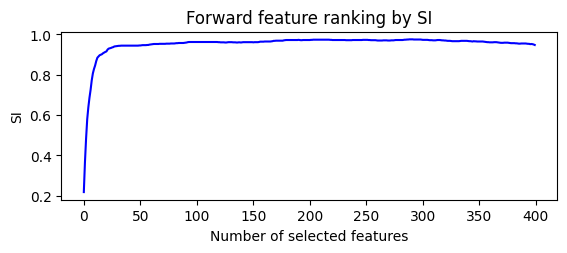

Ranked features are:  tensor([[228., 175., 133., 263.,   3., 128.,  34., 153., 241., 123., 298., 202.,
         177., 287., 302., 149., 178., 325., 388., 217.,  47., 114., 352.,  62.,
          99., 209., 239., 316.,  21.,  33., 329., 369.,  11., 335., 243., 258.,
         311., 320., 337., 345., 355., 356., 357., 364., 365., 366., 383., 346.,
         394., 349., 350., 359., 368.,  32., 249.,  14., 198.,   0., 164., 326.,
          78., 199., 378.,  71.,  61.,  70., 100., 109., 259., 260.,  67.,  49.,
         162., 397.,  19.,  77., 270., 321.,  51.,  52.,  64., 230.,  91.,  30.,
         160.,  10., 267.,  50.,  90., 174., 218., 210., 252., 330.,   1.,  42.,
         207., 313., 322., 327., 328., 338., 339., 344., 347., 348., 354., 358.,
         367., 370., 373., 374., 375., 376., 377., 381., 384., 385., 393.,  20.,
          31.,  23., 323., 386., 340.,  53., 170., 273., 271., 257., 314., 336.,
          41., 150., 244., 166., 167., 176., 353., 126.,  48., 395.,  73.,  76.,
      

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(si_ranked_features.cpu().detach().numpy(), 'b')
plt.xlabel("Number of selected features")
plt.ylabel("SI")
plt.title("Forward feature ranking by SI")
plt.show()
si_ranked_features = torch.transpose(si_ranked_features, 0, 1)
print('Ranked features are: ', ranked_features)
print('si for the best chosen Features are: ', si_ranked_features.detach().cpu().numpy())

In [ ]:
si_ranked_features = si_ranked_features.cpu().detach().numpy()
max_index = np.argmax(si_ranked_features)

In [ ]:
print(max_index)

288


In [ ]:
final_selected_features = features[:, :max_index]

In [ ]:
final_selected_features.shape

torch.Size([1220, 288])

#Part 2

## Train and validation data set

In [ ]:
batch_size = 64

In [ ]:
#creat data set with final_selected_features and train_labels
dataset = TensorDataset(final_selected_features, train_labels)

#creat train and validation dataset
dataset_size = len(final_selected_features)
val_ratio = 0.2
train_ratio = 0.8

val_size = int(dataset_size * val_ratio)
train_size = dataset_size - val_size


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#creat train dataloader and val dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

##Train classifier of model

In [ ]:
# Define the AlexNet model
class Classifier_AlexNet(nn.Module):
    def __init__(self, num=10):
        super(Classifier_AlexNet, self).__init__()

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(max_index,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num),
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [ ]:
model2 = Classifier_AlexNet()

In [ ]:
#Definition optimal function and loss function
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.00001)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model2.to(device)

Classifier_AlexNet(
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=288, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [ ]:
# Train classifier model
train_accs = []
val_accs = []
train_losses = []
val_losses = []

num_epochs = 400
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.unsqueeze(dim=1)

        optimizer.zero_grad()


        outputs = model2(inputs)
        outputs = outputs.squeeze()
        labels = labels.squeeze(dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    model2.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.unsqueeze(dim=1)
            labels = labels.squeeze(dim=1)




            outputs = model2(inputs)
            outputs = outputs.squeeze()

            val_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)
    train_losses.append(running_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))

    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%' .format(epoch + 1, num_epochs, running_loss / len(train_dataloader), train_accuracy, val_accuracy))

Epoch [1/400], Loss: 2.3014, Train Accuracy: 11.17%, Validation Accuracy: 13.93%
Epoch [2/400], Loss: 2.2937, Train Accuracy: 15.57%, Validation Accuracy: 16.80%
Epoch [3/400], Loss: 2.2860, Train Accuracy: 18.44%, Validation Accuracy: 16.80%
Epoch [4/400], Loss: 2.2806, Train Accuracy: 21.72%, Validation Accuracy: 25.82%
Epoch [5/400], Loss: 2.2716, Train Accuracy: 26.64%, Validation Accuracy: 30.33%
Epoch [6/400], Loss: 2.2648, Train Accuracy: 30.12%, Validation Accuracy: 34.02%
Epoch [7/400], Loss: 2.2567, Train Accuracy: 33.61%, Validation Accuracy: 39.34%
Epoch [8/400], Loss: 2.2484, Train Accuracy: 34.73%, Validation Accuracy: 43.85%
Epoch [9/400], Loss: 2.2389, Train Accuracy: 36.89%, Validation Accuracy: 45.49%
Epoch [10/400], Loss: 2.2298, Train Accuracy: 40.16%, Validation Accuracy: 47.95%
Epoch [11/400], Loss: 2.2197, Train Accuracy: 42.62%, Validation Accuracy: 50.00%
Epoch [12/400], Loss: 2.2080, Train Accuracy: 44.47%, Validation Accuracy: 51.64%
Epoch [13/400], Loss: 2.1

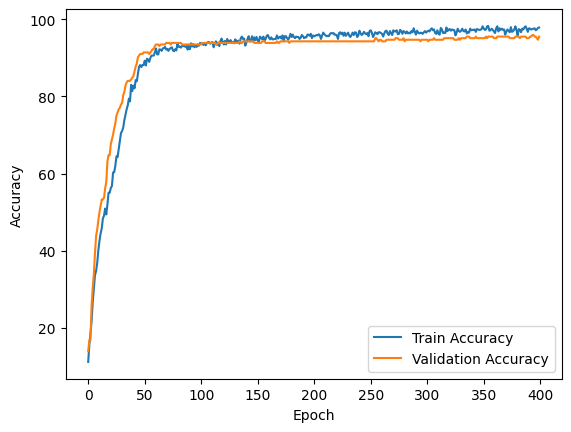

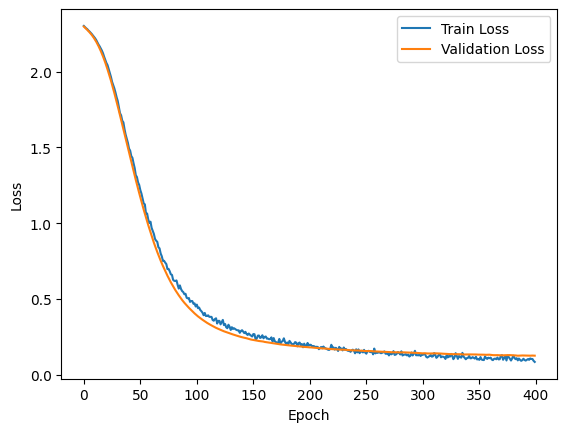

In [ ]:
#Plot Accuracy during train
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plot Loss during train
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Evaluation

###Test Data set

In [ ]:
# Define dataset transformations and load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [ ]:
# Get the data and labels from the test set:
test_images = torch.stack([testset[i][0] for i in range(len(testset))])
test_labels = torch.tensor([testset[i][1] for i in range(len(testset))])

#reshape labels
test_labels = test_labels.view(-1, 1)

In [ ]:
test_images = test_images.to(device)

In [ ]:
model = model.to(device)

In [ ]:
# Create a forward hook function to capture features before the fully connected layers
features = None

def hook(module, input, output):
    global features
    features = output


# Register the hook to the last layer before the fully connected layers
model.feature[-1].register_forward_hook(hook)


# Pass data through the model
with torch.no_grad():
    output = model(test_images)

In [ ]:
features = features.view(features.size(0),-1)

In [ ]:
test_features = features[:,:max_index]

In [ ]:
#creat data set with test_features and test_labels
test_dataset = TensorDataset(test_features, test_labels)

#creat test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

###evaluate model with test data set

In [ ]:
model.to(device)

AlexNet(
  (feature): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequent

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        images = images.unsqueeze(dim=1)


        outputs = model2(images)
        outputs = outputs.squeeze()
        # print("aaaaaaa",outputs.shape)
        labels = labels.squeeze(dim=1)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = (correct / total)*100
print('Accuracy For Test Dataset ', accuracy)

Accuracy For Test Dataset  96.14
